# Capstone Project

One of the bank product is loan. in order to reduce risk of potential loss in revenue, a bank is taking a collateral for the loan. lot of people giving his home as a collateral. A collateral value is the estimated fair market value of an asset that is being used as loan collateral. Collateral value is determined by appraisal from a qualified expert. usually, the bank hire appraisal company to do this task. In this project, i will try to create a regression model for houses prices. the aim is helping the bank to estimate houses price, so the bank doesn't too much dependent on the appraisal company. 

First, we need to install and load all library that needed

In [25]:
!pip install requests 
!pip install uszipcode

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import math 
from uszipcode import SearchEngine
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

Then, load the data that we are needed <br>

The data is house sales from King County, Washington State. the data is taken from kaggle. <br> The data will be joined with data taken from foursquare API nearby venues. <br> 
Joined data will be used to create regression houses prices model.

In [28]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_6b9fbeefaeba40ac93679ac9733e804a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='oivAIFt4tSHxPVU2FF39mceeAyCC2ttSNAeJKayIzohw',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_6b9fbeefaeba40ac93679ac9733e804a.get_object(Bucket='applieddatasciencecapstone-donotdelete-pr-zeyld6mpcottxh',Key='kc_house_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


remove duplicate, reset index and drop duplicate

In [29]:
df_data_1 = df_data_1.dropna()
df_data_1.reset_index(inplace=True)
df_data_1 = df_data_1.drop_duplicates(keep='last')

some change will be done to the houses dataset feature : <br>
change year built feature into age of building, and year renovated to become age of last renovation<br>
zipcode to change into neighborhood<br>
date,id, lat and long will be removed

In [30]:
df_data_1.loc[df_data_1['yr_renovated'] == 0, ['yr_renovated']] = df_data_1["yr_built"]

In [31]:
df_data_1["yr_renovated"] = df_data_1["date"].astype(str).str[0:4].astype(int) - df_data_1["yr_renovated"]

In [32]:
df_data_1["yr_built"] = df_data_1["date"].astype(str).str[0:4].astype(int) - df_data_1["yr_built"]

In [ ]:
df_data_1["city"] = ""
for x in range(21611):
    search = SearchEngine()
    zipcode = search.by_zipcode(df_data_1["zipcode"][x])
    df_data_1["city"][x] = zipcode.major_city

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Then, The Foursquare Data will Be Gathered using this code

In [4]:
def getNearbyVenues(index, latitudes, longitudes, radius=1000):
    venues_list=[]
        
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitudes, 
            longitudes, 
            radius, 
            100)
            
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
        
    # return only relevant information for each nearby venue
    if not (not results):
        venues_list.append([(
            index, 
            latitudes, 
            longitudes, 
            v['venue']['name'], 
            v['venue']['location']['distance'], 
            v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['index','Hs Latitude', 'Hs Longitude','Venue', 'Venue Distance','Venue Category']
    
        return(nearby_venues)

In [ ]:
venuesls = pd.DataFrame(columns = ['index', 'Hs Latitude', 'Hs Longitude', 'Venue', 'Venue Distance','Venue Category'])
for x in range(21445,21610):
    venues = getNearbyVenues(index=kchs['index'][x],
                         latitudes=kchs['lat'][x],
                         longitudes=kchs['long'][x])
    venuesls = venuesls.append(venues, sort = True)

delete unused column

In [3]:
df_data_1 = df_data_1.drop(['id','date','lat', 'long','zipcode'], axis=1)

because the process takes time. We will save two dataset above progress to seperate csv. <br>
and next we upload again two dataset above

In [2]:

body = client_6b9fbeefaeba40ac93679ac9733e804a.get_object(Bucket='applieddatasciencecapstone-donotdelete-pr-zeyld6mpcottxh',Key='NewData.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,city
0,0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,59,59,98178,1340,5650,Seattle
1,1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,63,23,98125,1690,7639,Seattle
2,2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,82,82,98028,2720,8062,Kenmore
3,3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,49,49,98136,1360,5000,Seattle
4,4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,28,28,98074,1800,7503,Sammamish


In [4]:

body = client_6b9fbeefaeba40ac93679ac9733e804a.get_object(Bucket='applieddatasciencecapstone-donotdelete-pr-zeyld6mpcottxh',Key='MasterData.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

venuesls = pd.read_csv(body)
venuesls.head()


,Unnamed: 0,Hs Latitude,Hs Longitude,Venue,Venue Category,Venue Distance,index
0,0,47.5112,-122.257,Pizzeria Pulcinella,Pizza Place,668,0.0
1,1,47.5112,-122.257,Kubota Garden,Garden,674,0.0
2,2,47.5112,-122.257,The Stone House Cafe,Café,597,0.0
3,3,47.5112,-122.257,Redwing Cafe,Café,990,0.0
4,4,47.5112,-122.257,Upper Rainier Beach,Gun Range,380,0.0


for dataset that generated from foursquare API we dont really need venue name, distance, lat and long , we should remove unused column

Now, we try to one hot encode both of the dataset. for price dataset, we try to one hot encode city, and for foursquare API, we one hot encode Venue Category

price dataset first

In [6]:
enc = OneHotEncoder(sparse=False)
city = df_data_1["city"].values.reshape(-1,1)
city = enc.fit_transform(city)
city = pd.DataFrame(city)
city.columns = enc.get_feature_names()

In [7]:
city.head()

,x0_Auburn,x0_Bellevue,x0_Black Diamond,x0_Bothell,x0_Carnation,x0_Duvall,x0_Enumclaw,x0_Fall City,x0_Federal Way,x0_Issaquah,x0_Kenmore,x0_Kent,x0_Kirkland,x0_Maple Valley,x0_Medina,x0_Mercer Island,x0_North Bend,x0_Redmond,x0_Renton,x0_Sammamish,x0_Seattle,x0_Snoqualmie,x0_Vashon,x0_Woodinville
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Merge df_data_1 with one hot encode result

In [8]:
df_data_1 = pd.concat([df_data_1, city], axis = 1)

In [9]:
df_data_1 = df_data_1.drop(['city'], axis=1)
del city

In [10]:
df_data_1.head()

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,x0_Auburn,x0_Bellevue,x0_Black Diamond,x0_Bothell,x0_Carnation,x0_Duvall,x0_Enumclaw,x0_Fall City,x0_Federal Way,x0_Issaquah,x0_Kenmore,x0_Kent,x0_Kirkland,x0_Maple Valley,x0_Medina,x0_Mercer Island,x0_North Bend,x0_Redmond,x0_Renton,x0_Sammamish,x0_Seattle,x0_Snoqualmie,x0_Vashon,x0_Woodinville
0,0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,59,59,1340,5650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,63,23,1690,7639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,82,82,2720,8062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,49,49,1360,5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,28,28,1800,7503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


next, venues dataset

In [11]:
ven = venuesls["Venue Category"].values.reshape(-1,1)
vens = enc.fit_transform(ven)
del ven
vens = pd.DataFrame(vens)
vens.columns = enc.get_feature_names()
venuesls = venuesls.drop(["Venue Category"], axis=1)

In [12]:
vens.head()

,x0_ATM,x0_Accessories Store,x0_Adult Boutique,x0_Advertising Agency,x0_Afghan Restaurant,x0_African Restaurant,x0_Airport,x0_Airport Lounge,x0_Airport Service,x0_Airport Terminal,x0_Alternative Healer,x0_American Restaurant,x0_Amphitheater,x0_Animal Shelter,x0_Antique Shop,x0_Apres Ski Bar,x0_Arcade,x0_Argentinian Restaurant,x0_Art Gallery,x0_Art Museum,x0_Art Studio,x0_Arts & Crafts Store,x0_Arts & Entertainment,x0_Asian Restaurant,x0_Assisted Living,x0_Astrologer,x0_Athletics & Sports,x0_Australian Restaurant,x0_Auto Dealership,x0_Auto Garage,x0_Auto Workshop,x0_Automotive Shop,x0_BBQ Joint,x0_Baby Store,x0_Badminton Court,x0_Bagel Shop,x0_Bakery,x0_Bank,x0_Bar,x0_Baseball Field,...,x0_Track,x0_Track Stadium,x0_Trade School,x0_Trail,x0_Train,x0_Train Station,x0_Tram Station,x0_Travel & Transport,x0_Travel Agency,x0_Tree,x0_Tunnel,x0_Turkish Restaurant,x0_Udon Restaurant,x0_University,x0_Used Bookstore,x0_Vacation Rental,x0_Vape Store,x0_Vegetarian / Vegan Restaurant,x0_Veterinarian,x0_Video Game Store,x0_Video Store,x0_Vietnamese Restaurant,x0_Vineyard,x0_Volleyball Court,x0_Warehouse Store,x0_Waste Facility,x0_Watch Shop,x0_Water Park,x0_Waterfall,x0_Waterfront,x0_Weight Loss Center,x0_Whisky Bar,x0_Wine Bar,x0_Wine Shop,x0_Winery,x0_Wings Joint,x0_Women's Store,x0_Yoga Studio,x0_Zoo,x0_Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


and merge venue dataset to the one hot encode result

In [13]:
venuesls = pd.concat([venuesls, vens], axis = 1)
del vens


Group by sum for all category by Index

In [14]:
venuesls = venuesls.groupby(['index']).sum()

In [15]:
venuesls.head()

,x0_ATM,x0_Accessories Store,x0_Adult Boutique,x0_Advertising Agency,x0_Afghan Restaurant,x0_African Restaurant,x0_Airport,x0_Airport Lounge,x0_Airport Service,x0_Airport Terminal,x0_Alternative Healer,x0_American Restaurant,x0_Amphitheater,x0_Animal Shelter,x0_Antique Shop,x0_Apres Ski Bar,x0_Arcade,x0_Argentinian Restaurant,x0_Art Gallery,x0_Art Museum,x0_Art Studio,x0_Arts & Crafts Store,x0_Arts & Entertainment,x0_Asian Restaurant,x0_Assisted Living,x0_Astrologer,x0_Athletics & Sports,x0_Australian Restaurant,x0_Auto Dealership,x0_Auto Garage,x0_Auto Workshop,x0_Automotive Shop,x0_BBQ Joint,x0_Baby Store,x0_Badminton Court,x0_Bagel Shop,x0_Bakery,x0_Bank,x0_Bar,x0_Baseball Field,...,x0_Track,x0_Track Stadium,x0_Trade School,x0_Trail,x0_Train,x0_Train Station,x0_Tram Station,x0_Travel & Transport,x0_Travel Agency,x0_Tree,x0_Tunnel,x0_Turkish Restaurant,x0_Udon Restaurant,x0_University,x0_Used Bookstore,x0_Vacation Rental,x0_Vape Store,x0_Vegetarian / Vegan Restaurant,x0_Veterinarian,x0_Video Game Store,x0_Video Store,x0_Vietnamese Restaurant,x0_Vineyard,x0_Volleyball Court,x0_Warehouse Store,x0_Waste Facility,x0_Watch Shop,x0_Water Park,x0_Waterfall,x0_Waterfront,x0_Weight Loss Center,x0_Whisky Bar,x0_Wine Bar,x0_Wine Shop,x0_Winery,x0_Wings Joint,x0_Women's Store,x0_Yoga Studio,x0_Zoo,x0_Zoo Exhibit
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


now join this two dataset using index

In [16]:
df_data_1 = df_data_1.merge(venuesls, left_on='index', right_on='index', how='left')
del venuesls

In [17]:
df_data_1.head()

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,x0_Auburn,x0_Bellevue,x0_Black Diamond,x0_Bothell,x0_Carnation,x0_Duvall,x0_Enumclaw,x0_Fall City,x0_Federal Way,x0_Issaquah,x0_Kenmore,x0_Kent,x0_Kirkland,x0_Maple Valley,x0_Medina,x0_Mercer Island,x0_North Bend,x0_Redmond,x0_Renton,x0_Sammamish,x0_Seattle,x0_Snoqualmie,x0_Vashon,...,x0_Track,x0_Track Stadium,x0_Trade School,x0_Trail,x0_Train,x0_Train Station,x0_Tram Station,x0_Travel & Transport,x0_Travel Agency,x0_Tree,x0_Tunnel,x0_Turkish Restaurant,x0_Udon Restaurant,x0_University,x0_Used Bookstore,x0_Vacation Rental,x0_Vape Store,x0_Vegetarian / Vegan Restaurant,x0_Veterinarian,x0_Video Game Store,x0_Video Store,x0_Vietnamese Restaurant,x0_Vineyard,x0_Volleyball Court,x0_Warehouse Store,x0_Waste Facility,x0_Watch Shop,x0_Water Park,x0_Waterfall,x0_Waterfront,x0_Weight Loss Center,x0_Whisky Bar,x0_Wine Bar,x0_Wine Shop,x0_Winery,x0_Wings Joint,x0_Women's Store,x0_Yoga Studio,x0_Zoo,x0_Zoo Exhibit
0,0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,59,59,1340,5650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,63,23,1690,7639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,82,82,2720,8062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,49,49,1360,5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,28,28,1800,7503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [18]:
df_data_1 = df_data_1.fillna(0)

okay, next we save the current progress of the data, and then load it again to df_data_1 dataframe

In [2]:

body = client_6b9fbeefaeba40ac93679ac9733e804a.get_object(Bucket='applieddatasciencecapstone-donotdelete-pr-zeyld6mpcottxh',Key='MasterData.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


next, we do exploratory analysis, this analysis will focusing to help build the regression model <br>
first we describe the dataset

In [4]:
df_data_1.describe()

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,x0_Auburn,x0_Bellevue,x0_Black Diamond,x0_Bothell,x0_Carnation,x0_Duvall,x0_Enumclaw,x0_Fall City,x0_Federal Way,x0_Issaquah,x0_Kenmore,x0_Kent,x0_Kirkland,x0_Maple Valley,x0_Medina,x0_Mercer Island,x0_North Bend,x0_Redmond,x0_Renton,x0_Sammamish,x0_Seattle,x0_Snoqualmie,x0_Vashon,...,x0_Track,x0_Track Stadium,x0_Trade School,x0_Trail,x0_Train,x0_Train Station,x0_Tram Station,x0_Travel & Transport,x0_Travel Agency,x0_Tree,x0_Tunnel,x0_Turkish Restaurant,x0_Udon Restaurant,x0_University,x0_Used Bookstore,x0_Vacation Rental,x0_Vape Store,x0_Vegetarian / Vegan Restaurant,x0_Veterinarian,x0_Video Game Store,x0_Video Store,x0_Vietnamese Restaurant,x0_Vineyard,x0_Volleyball Court,x0_Warehouse Store,x0_Waste Facility,x0_Watch Shop,x0_Water Park,x0_Waterfall,x0_Waterfront,x0_Weight Loss Center,x0_Whisky Bar,x0_Wine Bar,x0_Wine Shop,x0_Winery,x0_Wings Joint,x0_Women's Store,x0_Yoga Studio,x0_Zoo,x0_Zoo Exhibit
count,21611.000000,2.161100e+04,21611.000000,21611.000000,21611.000000,2.161100e+04,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,...,21611.000000,21611.00000,21611.000000,21611.000000,21611.000000,21611.000000,21611.00000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.00000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000
mean,10806.998797,5.400850e+05,3.370830,2.114791,2079.853454,1.510771e+04,1.494332,0.007542,0.234325,3.409421,7.656888,1788.396095,291.457360,43.314978,40.933876,1986.559576,12769.025357,0.042201,0.065059,0.004627,0.009023,0.005738,0.008792,0.010828,0.003748,0.036046,0.033918,0.013095,0.055666,0.045208,0.027301,0.002314,0.013049,0.010226,0.045301,0.073898,0.037018,0.415344,0.014345,0.005460,...,0.014900,0.00273,0.000463,0.341863,0.000694,0.006524,0.00273,0.004026,0.001666,0.014067,0.004997,0.021424,0.002129,0.000602,0.003841,0.000555,0.001111,0.072694,0.002776,0.036555,0.291009,0.330480,0.000509,0.001712,0.019064,0.002221,0.000648,0.002082,0.00074,0.002175,0.016704,0.009671,0.090695,0.049142,0.019435,0.047615,0.036093,0.157142,0.006663,0.131461
std,6238.704752,3.671430e+05,0.930092,0.770157,918.422406,4.142235e+04,0.540003,0.086521,0.766350,0.650755,1.175502,828.128162,442.487355,29.374462,28.812296,685.416548,27305.369808,0.201051,0.246636,0.067868,0.094563,0.075533,0.093354,0.103494,0.061108,0.186410,0.181022,0.113685,0.229281,0.207766,0.162963,0.048046,0.113487,0.100609,0.207968,0.261610,0.188811,0.492793,0.118909,0.073693,...,0.121155,0.05218,0.021507,0.628872,0.026337,0.080512,0.05218,0.063322,0.040781,0.122771,0.070517,0.145753,0.046088,0.024520,0.061855,0.023558,0.033307,0.344642,0.052619,0.212205,0.556516,1.085211,0.022556,0.041343,0.137766,0.047077,0.025445,0.045585,0.02720,0.046585,0.128165,0.097867,0.374094,0.252687,0.214883,0.216403,0.243931,0.440139,0.081358,1.524222
min,0.000000,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,-1.000000,-1.000000,399.000000,651.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

the range of the data varies, and most of the data are dummy variable
next we try to boxplot only the non dummy variable to check outlier

In [5]:
dummy = df_data_1.iloc[:,np.r_[1:6,8:16]]
dummy.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15
0,221900.0,3,1.00,1180,5650,0,3,7,1180.0,0,59,59,1340
1,538000.0,3,2.25,2570,7242,0,3,7,2170.0,400,63,23,1690
2,180000.0,2,1.00,770,10000,0,3,6,770.0,0,82,82,2720
3,604000.0,4,3.00,1960,5000,0,5,7,1050.0,910,49,49,1360
4,510000.0,3,2.00,1680,8080,0,3,8,1680.0,0,28,28,1800


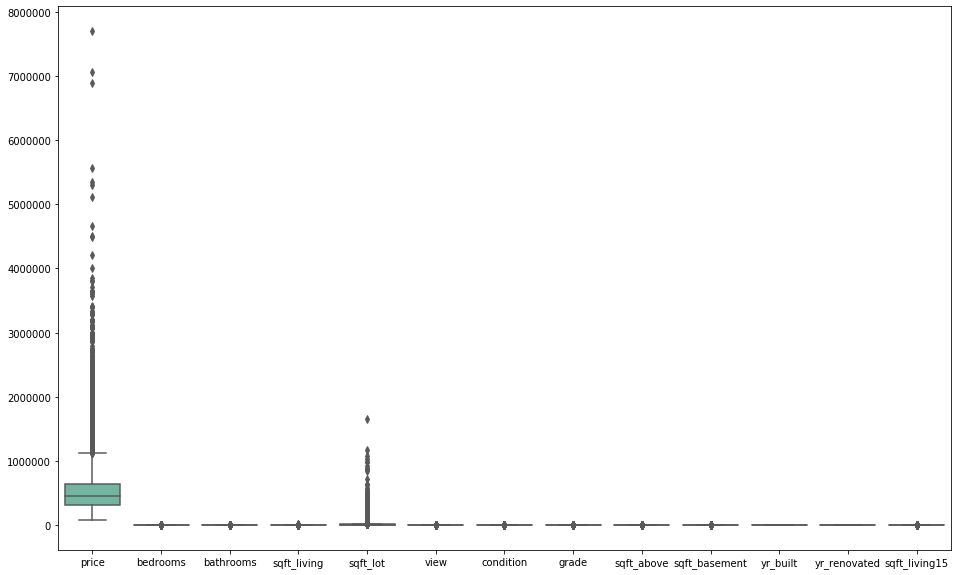

In [6]:
plt.figure(figsize=(16, 10))
ax = sns.boxplot(data=dummy, orient="v", palette="Set2")

turns out the one who has lot of outlier is sqft_lot and price, for now we wont touch this outlier first.

we will check the multicollienarity between all variable

In [7]:
corr = df_data_1.corr()

In [8]:
corr

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,x0_Auburn,x0_Bellevue,x0_Black Diamond,x0_Bothell,x0_Carnation,x0_Duvall,x0_Enumclaw,x0_Fall City,x0_Federal Way,x0_Issaquah,x0_Kenmore,x0_Kent,x0_Kirkland,x0_Maple Valley,x0_Medina,x0_Mercer Island,x0_North Bend,x0_Redmond,x0_Renton,x0_Sammamish,x0_Seattle,x0_Snoqualmie,x0_Vashon,...,x0_Track,x0_Track Stadium,x0_Trade School,x0_Trail,x0_Train,x0_Train Station,x0_Tram Station,x0_Travel & Transport,x0_Travel Agency,x0_Tree,x0_Tunnel,x0_Turkish Restaurant,x0_Udon Restaurant,x0_University,x0_Used Bookstore,x0_Vacation Rental,x0_Vape Store,x0_Vegetarian / Vegan Restaurant,x0_Veterinarian,x0_Video Game Store,x0_Video Store,x0_Vietnamese Restaurant,x0_Vineyard,x0_Volleyball Court,x0_Warehouse Store,x0_Waste Facility,x0_Watch Shop,x0_Water Park,x0_Waterfall,x0_Waterfront,x0_Weight Loss Center,x0_Whisky Bar,x0_Wine Bar,x0_Wine Shop,x0_Winery,x0_Wings Joint,x0_Women's Store,x0_Yoga Studio,x0_Zoo,x0_Zoo Exhibit
index,1.000000,0.027391,0.010817,0.107279,0.044813,-0.026912,0.179094,-0.007626,-0.013802,-0.095413,0.082040,0.071957,-0.041655,-0.199436,-0.191580,0.026633,-0.029867,0.011722,-0.021106,-0.014754,0.001235,-0.001284,0.003112,-0.005903,-0.013000,-0.019251,0.038268,-0.000673,-0.007588,-0.009815,0.002884,0.016241,-0.018472,-0.002914,0.000668,0.008411,-0.004780,0.007605,0.048048,-0.009688,...,0.000777,-0.007894,0.005010,0.009497,-0.001361,-0.009661,0.007653,-0.003857,-0.007308,-0.010566,0.014933,0.011909,0.017629,-0.001502,0.006033,-0.002092,-0.008621,0.012007,-0.007821,0.003625,-0.000922,0.024650,-0.012900,-0.008016,0.019686,-0.014578,-0.005014,-0.004472,0.019810,-0.004448,0.004284,0.020059,0.008441,0.030686,0.019911,-0.001040,0.002171,0.027677,0.014849,0.014192
price,0.027391,1.000000,0.308366,0.525150,0.702055,0.089661,0.256814,0.266371,0.397299,0.036379,0.667434,0.605567,0.323842,-0.053946,-0.105673,0.585377,0.082448,-0.142136,0.257424,-0.021621,-0.012926,-0.017478,-0.029577,-0.063942,0.006757,-0.132048,0.038281,-0.024349,-0.159069,0.062997,-0.079043,0.212559,0.204875,-0.027856,0.070470,-0.105134,0.102870,-0.011744,-0.003984,-0.010617,...,0.068538,0.081828,0.007303,0.147220,-0.014348,-0.064061,-0.009817,-0.039491,0.044533,0.050086,0.015891,0.100855,0.013291,0.014344,-0.002316,-0.013081,-0.028142,0.063206,-0.029695,-0.075760,-0.071590,-0.071031,-0.000503,0.011606,-0.023652,-0.019351,0.035401,-0.019369,-0.001229,0.060842,-0.029536,-0.012490,0.041948,0.055440,0.023242,-0.043791,-0.001417,0.108536,0.028764,0.024391
bedrooms,0.010817,0.308366,1.000000,0.515974,0.576763,0.031710,0.175418,-0.006581,0.079537,0.028433,0.356998,0.477616,0.303251,-0.154393,-0.165700,0.391670,0.029252,0.010345,0.128018,-0.005925,0.018251,-0.030289,-0.000777,-0.024889,-0.004915,0.006172,0.023687,0.013591,0.017770,0.032256,0.011666,0.035683,0.081292,-0.015307,0.018411,0.041609,0.075452,-0.182595,0.019683,-0.049122,...,-0.028913,0.041115,0.007615,0.032699,-0.010508,-0.029221,-0.019908,-0.001777,0.028853,0.019155,-0.013440,-0.023108,0.039879,0.008480,-0.027974,-0.019958,-0.011801,-0.036029,0.004491,-0.027421,-0.070908,-0.063794,-0.015615,0.000336,-0.030618,0.001268,0.003536,-0.005116,-0.005365,0.007018,-0.022853,-0.041434,-0.049584,-0.010597,-0.013139,-0.055082,-0.016367,-0.047854,-0.004525,-0.018329
bathrooms,0.107279,0.525150,0.515974,1.000000,0.754684,0.087730,0.500712,0.063743,0.187735,-0.124917,0.664981,0.685363,0.283737,-0.506356,-0.537423,0.568626,0.087163,-0.014999,0.098142,-0.007728,0.020247,-0.006550,0.021523,-0.027786,0.003886,-0.014641,0.099944,0.004236,-0.006052,0.028731,0.056789,0.067857,0.089809,-0.000519,0.080425,0.005611,0.124958,-0.241674,0.067415,-0.020624,...,0.004110,0.029913,0.017048,0.099478,-0.014194,-0.051819,-0.011541,-0.030589,0.032955,-0.007413,0.001152,-0.005008,-0.002647,0.008596,-0.012412,-0.009890,-0.031578,-0.034273,0.006123,-0.080395,-0.141562,-0.084827,0.000632,0.0047

sort 25 highest corr

In [9]:
s = corr.unstack()
so = s.sort_values(kind="quicksort")

print(so[314133:314158])


x0_Radio Station                 x0_Fountain                        0.786334
x0_Airport Terminal              x0_Airport                         0.791565
x0_Airport                       x0_Airport Terminal                0.791565
x0_High School                   x0_Scandinavian Restaurant         0.792833
x0_Scandinavian Restaurant       x0_High School                     0.792833
x0_Comfort Food Restaurant       x0_Whisky Bar                      0.812687
x0_Whisky Bar                    x0_Comfort Food Restaurant         0.812687
x0_Opera House                   x0_Radio Station                   0.813359
x0_Radio Station                 x0_Opera House                     0.813359
x0_Fountain                      x0_Opera House                     0.824592
x0_Opera House                   x0_Fountain                        0.824592
x0_Theme Park                    x0_Theme Park Ride / Attraction    0.827790
x0_Theme Park Ride / Attraction  x0_Theme Park                      0.827790

In [10]:
print(so[0:20])

yr_renovated   bathrooms       -0.537423
bathrooms      yr_renovated    -0.537423
yr_built       bathrooms       -0.506356
bathrooms      yr_built        -0.506356
floors         yr_renovated    -0.505695
yr_renovated   floors          -0.505695
floors         yr_built        -0.489681
yr_built       floors          -0.489681
grade          yr_renovated    -0.461180
yr_renovated   grade           -0.461180
grade          yr_built        -0.447411
yr_built       grade           -0.447411
yr_renovated   sqft_above      -0.436210
sqft_above     yr_renovated    -0.436210
yr_built       sqft_above      -0.424264
sqft_above     yr_built        -0.424264
sqft_living15  x0_Seattle      -0.373431
x0_Seattle     sqft_living15   -0.373431
sqft_above     x0_Seattle      -0.351338
x0_Seattle     sqft_above      -0.351338
dtype: float64


based on above, we can see there is a lot of multicollinearity between the independent variable, however we will only delete some of them that obviously correlated. fo example : zoo and zoo exhibit. we will remove the zoo exhibiy. and for roof deck and radio station, since its not obviously correlated, we will not remove the variable

we will remove this variable : <br> x0_Airport Terminal <br>
x0_Theme Park Ride / Attraction <br>
x0_Plane<br>
x0_Zoo Exhibit <br> 
sqft_above<br>

and also remove the index

In [11]:
df_data_1 = df_data_1.drop(['x0_Airport Terminal','x0_Theme Park Ride / Attraction','x0_Plane','x0_Zoo Exhibit','sqft_above','index'], axis=1)

now lets move to the modelling, first we need to divide to training and testing data

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df_data_1.iloc[:,1:], df_data_1['price'], test_size=0.25, random_state=99)

next, we try to reduce the feature by using RFE

In [13]:
lr = LinearRegression(normalize=True)
lr.fit(X_train,y_train)
rfe = RFECV(lr, min_features_to_select=1, cv = 10)
rfe.fit(X_train,y_train)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=True),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

checking RFE Result, total number of feature and the plot

In [64]:
rfe.n_features_

277

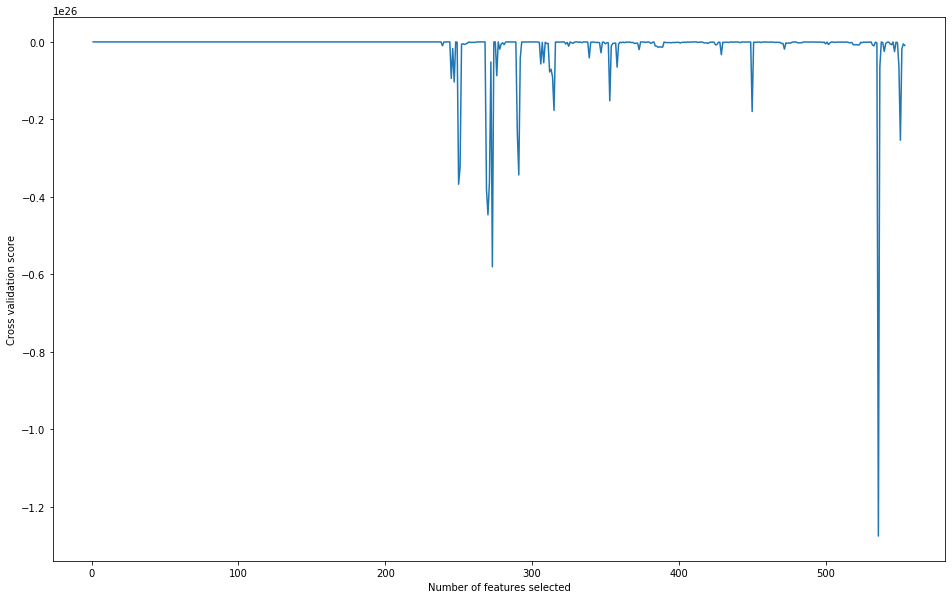

In [144]:
plt.figure(figsize=(16, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

Creating Dataframe RFE Result

In [66]:
colnames = df_data_1.columns

In [67]:
X_trnew = rfe.transform(X_train)

In [68]:
sp = rfe.support_

In [69]:
columns = X_train.columns

In [70]:
columns = columns[sp]

In [71]:
X_trnew = pd.DataFrame(X_trnew,columns=columns)

Now we will create a grid search CV linear regression to create regression model for the dataset

In [ ]:
y_train = y_train.reset_index()
y_test = y_test.reset_index()
y_train = y_train.drop(['index'], axis=1)
y_test = y_test.drop(['index'], axis=1)

In [99]:
result = []
    
cv = KFold(n_splits=4)

for i in range(1, 1000):
    alpha  = i * 0.001 
    rdg = Ridge(alpha= alpha, fit_intercept=True, normalize=True)
    
    for train_index, test_index in cv.split(X_trnew):
        X_train2, X_test2, y_train2, y_test2 = X_trnew.loc[train_index], X_trnew.loc[test_index], y_train.loc[train_index], y_train.loc[test_index]
        rdg.fit(X_train2, y_train2)
        y_pred = rdg.predict(X_test2)
        y_predtr = rdg.predict(X_train2)  
        s1 = rdg.score(X_train2, y_train2)
        m1 = mean_squared_error(y_train2, y_predtr)
        m2 = mean_squared_error(y_test2, y_pred)
        result.append([alpha,s1,m1,m2])                                                                             

In [100]:
result = pd.DataFrame(result)

In [111]:
result2 = result.groupby(0).mean()

In [114]:
result2.sort_values(by=1, ascending = False)

,1,2,3
0,,,
0.001,0.742933,3.556751e+10,3.896106e+10
0.002,0.742931,3.556777e+10,3.895510e+10
0.003,0.742928,3.556819e+10,3.894940e+10
0.004,0.742923,3.556879e+10,3.894395e+10
0.005,0.742918,3.556954e+10,3.893875e+10
...,...,...,...
0.995,0.645188,4.908038e+10,5.103360e+10
0.996,0.645082,4.909503e+10,5.104770e+10
0.997,0.644976,4.910968e+10,5.106181e+10


R Square Plot :

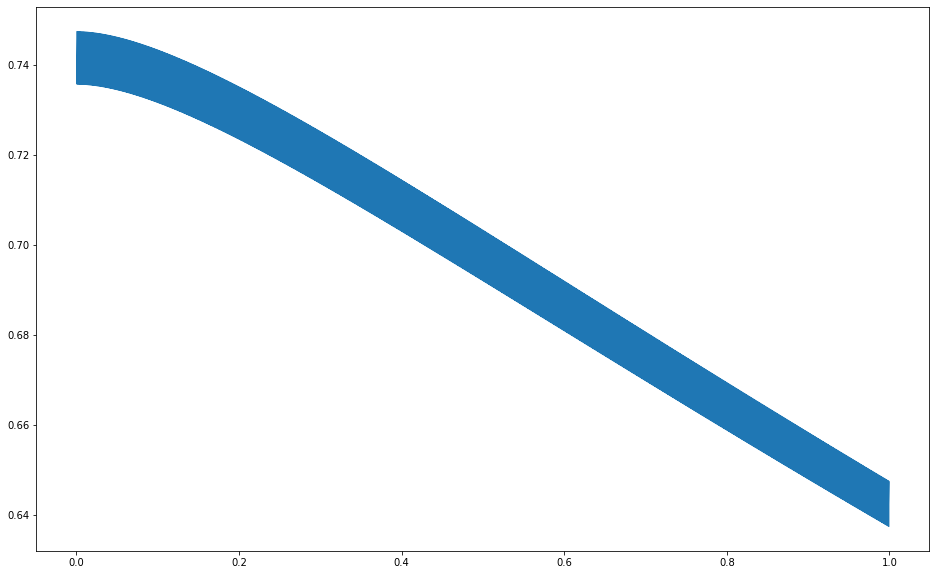

In [145]:
plt.figure(figsize=(16, 10))
ax = plt.axes()
ax.plot(result[0], result[1]);

In [199]:
res3 = result2.sort_values(by=3, ascending = True)
res3 = res3.iloc[0:10]
res3

,1,2,3
0,,,
0.034,0.742326,3.565136e+10,3.887255e+10
0.033,0.742359,3.564688e+10,3.887256e+10
0.035,0.742293,3.565595e+10,3.887269e+10
0.032,0.742390,3.564250e+10,3.887270e+10
0.036,0.742259,3.566064e+10,3.887296e+10
0.031,0.742421,3.563822e+10,3.887298e+10
0.037,0.742225,3.566542e+10,3.887336e+10
0.030,0.742451,3.563405e+10,3.887341e+10
0.038,0.742189,3.567031e+10,3.887390e+10


MSE Plot :

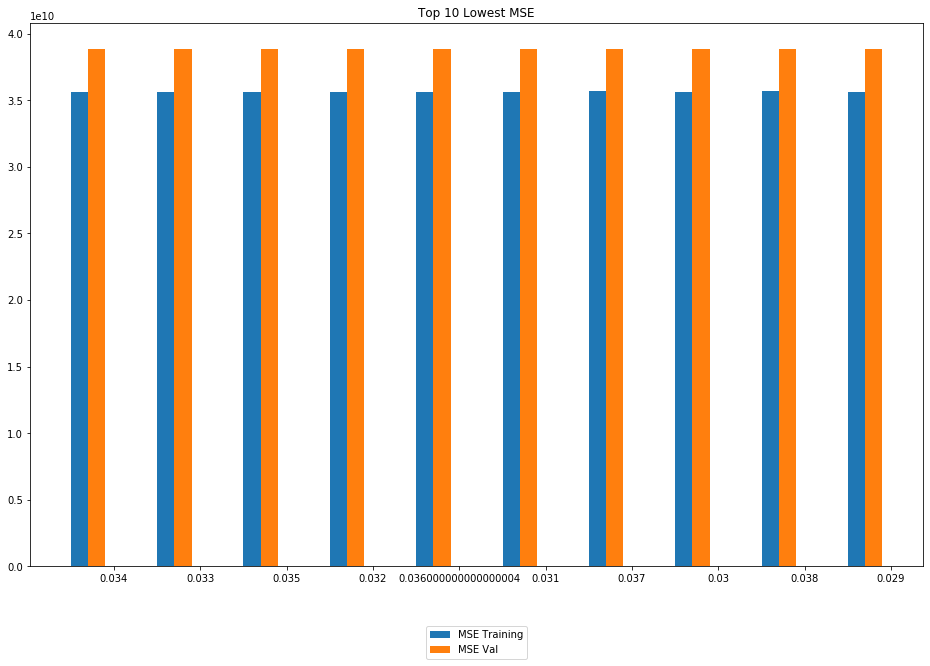

In [197]:
N = 10
fig, ax = plt.subplots(figsize=(16, 10))
ind = np.arange(N)   
width = 0.2         
p1 = ax.bar(ind-0.4, res3[2], width, bottom=0)
p2 = ax.bar(ind-width, res3[3], width, bottom=0)


ax.set_title('Top 10 Lowest MSE')
ax.set_xticks(ind)
ax.set_xticklabels(res3.index)
ax.legend((p1[0], p2[0]), ('MSE Training', 'MSE Val'), loc='upper center', bbox_to_anchor=(0.5,-0.1))
plt.show()

alpha that gives minimum MSE in validation data is 0.034, next we predict the model on the test set. the R square is also quite high, around 0.74

In [124]:
rdg2 = Ridge(alpha=0.034, fit_intercept=True, normalize=True)
rdg2.fit(X_train, y_train)
y_preds = rdg2.predict(X_test)
math.sqrt(mean_squared_error(y_test, y_preds))

156720.22790298864

In [138]:
y_test.describe()

,price
count,5.403000e+03
mean,5.383062e+05
std,3.524521e+05
min,7.500000e+04
25%,3.199500e+05
50%,4.500000e+05
75%,6.500000e+05
max,4.208000e+06


In [136]:
7.500000e+04 

75000.0

In [142]:
4.208000e+06

4208000.0

MSE for test set is ~156.000 with range of value price between 75.000 - 4.208.000 , not a bad value